# Old Optimists, Young Pessimists

This example is based no Chapter 10 of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

<IPython.core.display.Javascript object>

In [5]:
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

plt.rcParams["axes.titlesize"] = "medium"

plt.rcParams["font.size"] = 12

plt.rcParams["lines.linewidth"] = 1.5

plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.right"] = False

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.4
plt.rcParams["legend.facecolor"] = "none"
plt.rcParams["legend.edgecolor"] = "0.8"

plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.markeredgewidth"] = 0

<IPython.core.display.Javascript object>

## Old Optimists, Young Pessimists

Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves? Almost every year since 1972, the General Social Survey (GSS) has posed that question to a representative sample of adult residents of the United States.

The following figure shows how the responses have changed over time.
The circles show the percentage of people in each survey who said that people try to be helpful.

In [6]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [7]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 54)

<IPython.core.display.Javascript object>

In [8]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss["cohort"].isna().sum()

755

<IPython.core.display.Javascript object>

In [9]:
bins = np.arange(1879, 2011, 10)
labels = bins[:-1] + 1

gss["cohort10"] = pd.cut(gss["cohort"], bins, labels=labels)
gss["cohort10"].value_counts(dropna=False).sort_index()

cohort10
1880       45
1890      501
1900     1722
1910     3616
1920     5862
1930     7115
1940    10925
1950    14273
1960    11699
1970     7681
1980     5088
1990     2563
2000      545
NaN       755
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
def plot_titles(title, subtitle):
    """ """
    plt.title(title, loc="left", pad=20)

    ax = plt.gca()
    plt.text(
        0,
        1.02,
        subtitle,
        transform=ax.transAxes,
        color="0.2",
        ha="left",
        va="bottom",
        fontsize=11,
    )

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [11]:
from utils import make_lowess


def plot_series_lowess(series, plot_series=False, frac=0.7, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    color = options.pop("color", "C0")
    if "label" not in options:
        options["label"] = series.name

    x = series.index
    y = series.values
    if plot_series:
        plt.plot(x, y, "o", color=color, alpha=0.5, label="_")

    if not plot_series and len(series) == 1:
        plt.plot(x, y, "o", color=color, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [12]:
xlim = [1970.5, 2024.5]


def plot_by_year(varname, yvalue):
    xtab = pd.crosstab(gss["year"], gss[varname], normalize="index")

    by_year = xtab[yvalue] * 100
    by_year.name = varname

    plot_series_lowess(by_year, plot_series=True, color="C0", label="")

    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

In [13]:
from utils import prepare_yvar
from utils import chunk_series


def plot_by_cohort(yvarname, yvalue):
    xvarname = "cohort"

    prepare_yvar(gss, yvarname, yvalue)
    by_cohort = chunk_series(gss, xvarname, size=600) * 100

    plot_series_lowess(
        by_cohort,
        plot_series=True,
        color="C1",
        ls="dashed",
        label="",
    )

    decorate(
        xlabel="Year of birth",
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

In [14]:
from utils import get_colors
from utils import label_table


def visualize_table(table, nudge={}, **options):
    """Plot the results from make_table.

    table: map from group name to Series
    options: passed to plot
    """
    palette = options.pop("palette", "Purples")
    colors = get_colors(len(table), palette=palette)

    for i, series in enumerate(table.values()):
        label = f"{series.name}s"
        plot_series_lowess(
            series, color=colors[i], label=label, plot_series=False, **options
        )
    label_table(table, nudge)

    plot_titles(title, subtitle)
    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
        legend=False,
    )


<IPython.core.display.Javascript object>

## helpful

In [15]:
# https://gssdataexplorer.norc.org/variables/439/vshow

# 1 = helpful
# 2 = look out for themselves
# 3 = depends

<IPython.core.display.Javascript object>

In [16]:
varname = "helpful"
selected_value = 1

series = gss[varname]
series.value_counts()

helpful
1.0    20471
2.0    18972
3.0     2971
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
question = """Would you say that most of the time people try to be helpful, 
or that they are mostly just looking out for themselves?
"""

title = "Would people be helpful or look out for themselves?"
subtitle = "Percent saying helpful"
ylim = [15, 75]

<IPython.core.display.Javascript object>

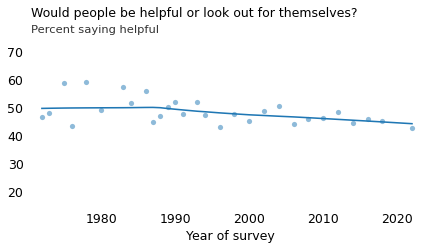

<IPython.core.display.Javascript object>

In [18]:
plot_by_year(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_year", dpi=300)

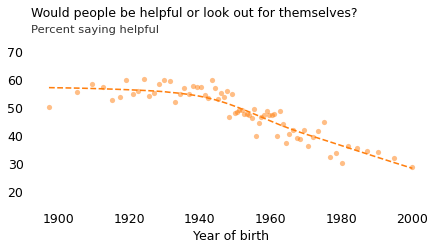

<IPython.core.display.Javascript object>

In [19]:
plot_by_cohort(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_cohort", dpi=300)

In [20]:
from utils import make_table

subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", varname, "cohort10", selected_value)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

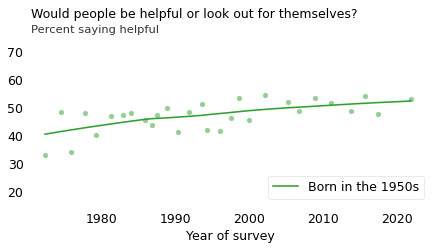

<IPython.core.display.Javascript object>

In [21]:
plot_series_lowess(table[1950], plot_series=True, color="C2", label="Born in the 1950s")

plot_titles(title, subtitle)
decorate(xlabel="Year of survey", ylim=ylim, xlim=xlim, loc="lower right")
plt.savefig(f"optimism_{varname}_one_cohort", dpi=300)

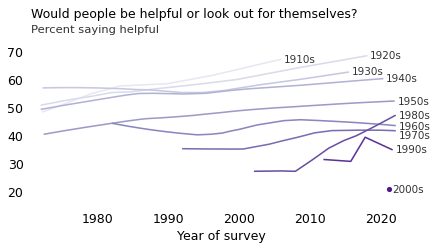

<IPython.core.display.Javascript object>

In [22]:
nudge = {"1960s": 0.5, "1970s": -0.5}
visualize_table(table, nudge)
plt.savefig(f"optimism_{varname}_by_cohort_over_year", dpi=300)

## trust

In [23]:
question = """Generally speaking, would you say that most people can be trusted 
or that you can't be too careful in dealing with people?
"""

title = "Can most people be trusted?"
subtitle = "Percent saying yes"
ylim = [5, 55]

<IPython.core.display.Javascript object>

In [24]:
# https://gssdataexplorer.norc.org/variables/441/vshow

# 1 = can trust
# 2 = can't be too careful
# 3 = depends

<IPython.core.display.Javascript object>

In [25]:
varname = "trust"
selected_value = 1

series = gss[varname]
series.value_counts()

trust
2.0    24890
1.0    15783
3.0     1966
Name: count, dtype: int64

<IPython.core.display.Javascript object>

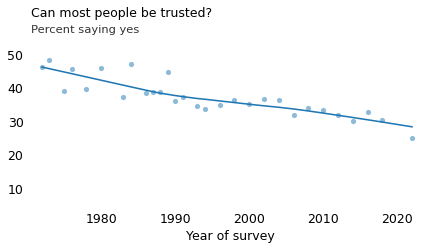

<IPython.core.display.Javascript object>

In [26]:
plot_by_year(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_year", dpi=300)

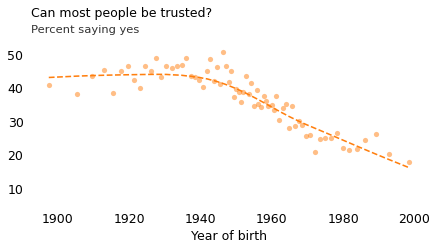

<IPython.core.display.Javascript object>

In [27]:
plot_by_cohort(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_cohort", dpi=300)

In [28]:
from utils import make_table

subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", varname, "cohort10", selected_value)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

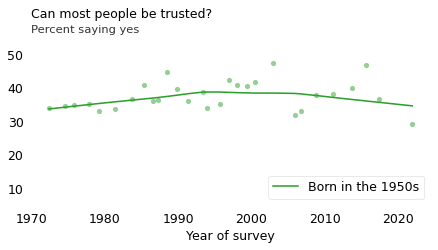

<IPython.core.display.Javascript object>

In [29]:
plot_series_lowess(table[1950], plot_series=True, color="C2", label="Born in the 1950s")

plot_titles(title, subtitle)
decorate(xlabel="Year of survey", ylim=ylim, loc="lower right")
plt.savefig(f"optimism_{varname}_one_cohort", dpi=300)

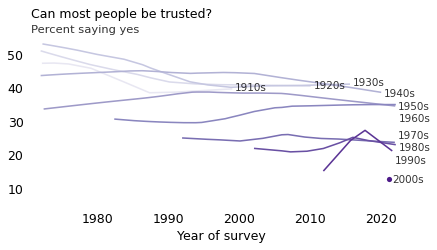

<IPython.core.display.Javascript object>

In [30]:
nudge = {"1960s": -4, "1970s": 2, "1980s": -1, "1990s": -3}
visualize_table(table, nudge)
plt.savefig(f"optimism_{varname}_by_cohort_over_year", dpi=300)

## fair

In [31]:
question = """Do you think most people would try to take advantage of 
you if they got a chance, or would they try to be fair?
"""

title = "Would people try to be fair?"
subtitle = "Percent saying yes"
ylim = [25, 75]

<IPython.core.display.Javascript object>

In [32]:
# https://gssdataexplorer.norc.org/variables/440/vshow

# 1 = would take advantage
# 2 = would try to be fair
# 3 = depends

<IPython.core.display.Javascript object>

In [33]:
varname = "fair"
selected_value = 2

series = gss[varname]
series.value_counts()

fair
2.0    23484
1.0    15979
3.0     2837
Name: count, dtype: int64

<IPython.core.display.Javascript object>

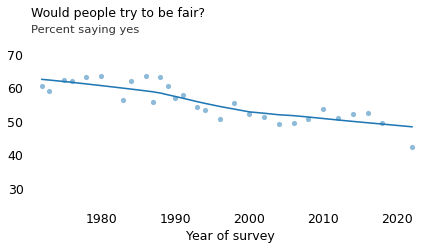

<IPython.core.display.Javascript object>

In [34]:
plot_by_year(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_year", dpi=300)

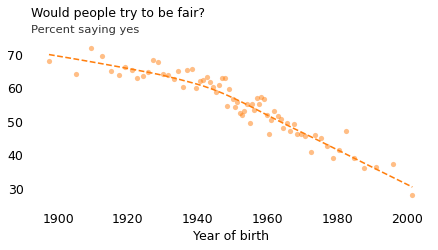

<IPython.core.display.Javascript object>

In [35]:
plot_by_cohort(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_cohort", dpi=300)

In [36]:
from utils import make_table

subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", varname, "cohort10", selected_value)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

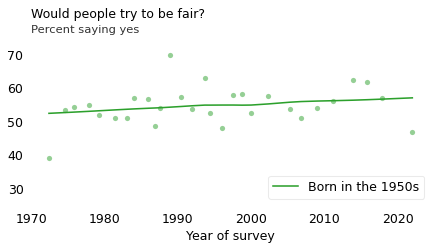

<IPython.core.display.Javascript object>

In [37]:
plot_series_lowess(table[1950], plot_series=True, color="C2", label="Born in the 1950s")

plot_titles(title, subtitle)
decorate(xlabel="Year of survey", ylim=ylim, loc="lower right")
plt.savefig(f"optimism_{varname}_one_cohort", dpi=300)

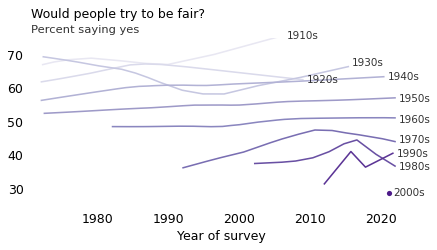

<IPython.core.display.Javascript object>

In [38]:
nudge = {"1960s": 0, "1970s": 2, "1980s": 0, "1990s": 0}
visualize_table(table, nudge)
plt.savefig(f"optimism_{varname}_by_cohort_over_year", dpi=300)

## happy

In [39]:
question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

title = "Are you happy?"
subtitle = "Percent saying very happy"
ylim = [10, 45]

<IPython.core.display.Javascript object>

In [40]:
# https://gssdataexplorer.norc.org/variables/452/vshow

# 1 = very happy
# 2 = pretty happy
# 3 = not too happy

<IPython.core.display.Javascript object>

In [41]:
varname = "happy"
selected_value = 1

series = gss[varname]
series.value_counts()

happy
2.0    37446
1.0    21550
3.0     8681
Name: count, dtype: int64

<IPython.core.display.Javascript object>

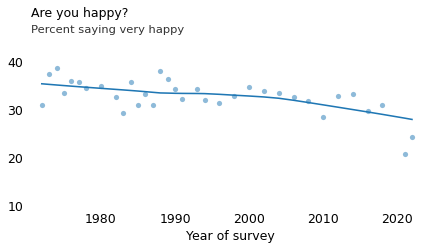

<IPython.core.display.Javascript object>

In [42]:
plot_by_year(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_year", dpi=300)

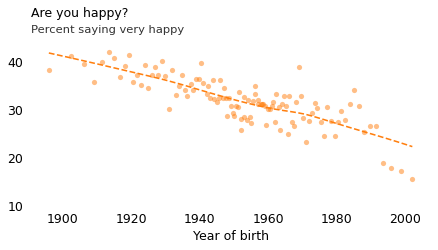

<IPython.core.display.Javascript object>

In [43]:
plot_by_cohort(varname, selected_value)
plt.savefig(f"optimism_{varname}_by_cohort", dpi=300)

In [44]:
from utils import make_table

subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", varname, "cohort10", selected_value)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

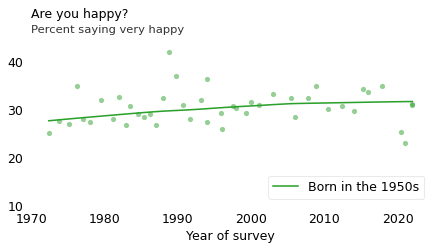

<IPython.core.display.Javascript object>

In [45]:
plot_series_lowess(table[1950], plot_series=True, color="C2", label="Born in the 1950s")

plot_titles(title, subtitle)
decorate(xlabel="Year of survey", ylim=ylim, loc="lower right")
plt.savefig(f"optimism_{varname}_one_cohort", dpi=300)

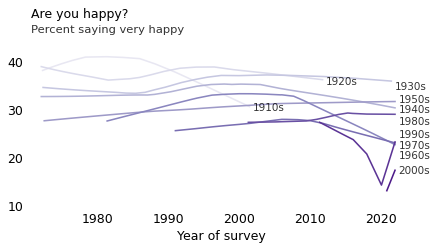

<IPython.core.display.Javascript object>

In [46]:
nudge = {"1950s": 0.5, "1960s": -1.8, "1970s": -0.5, "1980s": -1.5, "1990s": 1.6}
visualize_table(table, nudge)
plt.savefig(f"optimism_{varname}_by_cohort_over_year", dpi=300)

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).